In [271]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from xmitgcm import utils
from xmitgcm import open_mdsdataset
from xgcm import Grid
from xhistogram.xarray import histogram

In [272]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [273]:
time_release = np.datetime64('2021-07-01T04:00:00')

In [274]:
ds = xr.open_dataset("data/tracer_stats.nc").sel(time=slice(time_release, None))
ds['time'] = ds['time'] - time_release

In [275]:
t_obs = np.array(
    [0,      2,     4,    15,    19,    23,   27,      30,    32,   35,    37,   40,    42])*3600.
ρ_obs = 27.75+0.025*np.array(
    [0.4, 0.42, -0.05, -0.05, -0.45, -0.46, -0.5, -0.0525, -0.85, -0.7, -0.05, -0.7, -1.15])

dρdt, ρ0fit = np.polyfit(t_obs, ρ_obs, 1.)

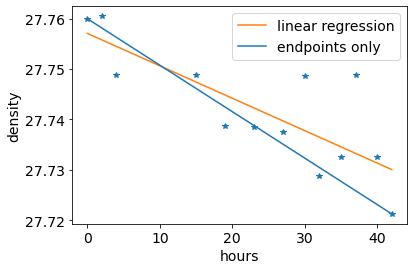

In [299]:
plt.plot(t_obs / 3600., ρ_obs, "*")
plt.plot(t_obs / 3600., t_obs*dρdt + ρ0fit, label="linear regression")
plt.plot(t_obs[[0, -1]] / 3600., ρ_obs[[0, -1]], "C0", label="endpoints only")
plt.ylabel("density")
plt.xlabel("hours")
plt.legend()

In [300]:
import gsw

In [301]:
ρ0 = 1035.
g = 9.81

ω_fit = 0.5*( -g/ρ0*dρdt)

In [302]:
dTdt = np.diff(ds['THETA_bar'])/(np.diff(ds['time'])*1e-9).astype("float64")

In [304]:
dTdz = 3.e-3
α = gsw.alpha(5., 35., 1800)
N2 = g*α*dTdz
N = np.sqrt(N2)

z0 = -1800.
pref = gsw.p_from_z(z0, 54.20)
ds['RHO_bar'] = gsw.rho(ds['SALT_bar'], ds['THETA_bar'], pref)

In [305]:
ω_sim = 0.5*( -g/ρ0*(np.diff(ds['RHO_bar'])/(np.diff(ds['time'])*1e-9).astype("float64")) )
ω_obs = 0.5*( -g/ρ0*(np.diff(ρ_obs)/np.diff(t_obs)) )

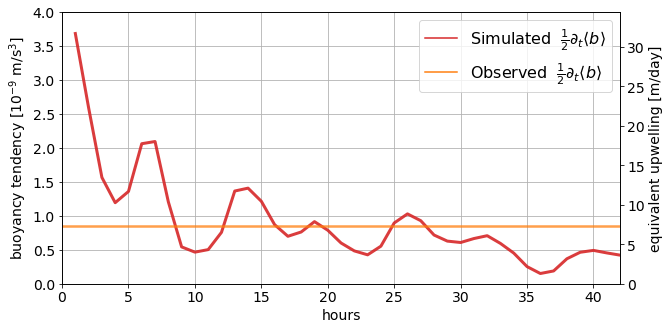

In [306]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot()
ax2 = ax.twinx()

ax.plot(0.5*(ds['time'][1:].astype("float64").values + ds['time'][:-1].astype("float64").values) * 1e-9 / 3600., 1.e9 * ω_sim, "C3-", lw=3, alpha=0.9)
ax.axhline(1.e9 * ω_fit, color="C1", lw=2.5, alpha=0.75)
ax.set_xlim(0, 42)
ax.set_ylim(0, 4)
ax.set_xlabel("hours")
ax.set_ylabel(r"buoyancy tendency [10$^{-9}$ m/s$^{3}$]")

ylims = ax.get_ylim()
ax2.set_ylim( np.array(ylims) / ( 1e9 * N**2) * 86400. )
ax2.set_ylabel("equivalent upwelling [m/day]")

plt.plot([], [], "C3", label=r"Simulated $\;\frac{1}{2} \partial_{t} \langle  b \rangle$")
plt.plot([], [], "C1", label=r"Observed $\;\frac{1}{2}\partial_{t} \langle  b \rangle$")
plt.legend(loc="upper right", fontsize=16)

ax.grid(True)
plt.savefig("figures/BLT_upwelling", dpi=150., bbox_inches="tight")